In [4]:
import cv2
import numpy as np
import time

In [2]:
cap = cv2.VideoCapture(0)
#rem=cv2.createBackgroundSubtractorMOG2()

lower_skin = np.array([0,20,70], dtype=np.uint8)
upper_skin = np.array([20,255,255], dtype=np.uint8)
img_counter=68
while(True):
    # Capture frame-by-frame
  
    ret, frame = cap.read()
    frame=cv2.flip(frame,1)
    roi=frame[10:350,340:620]
    
    kernel = np.ones((3,3),np.uint8)
    
    cv2.rectangle(frame,(340,10),(620,350),(0,255,0),2)
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    
    
    #mask = cv2.inRange(hsv, lower_skin, upper_skin)
    
   
    #mask=cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    #mask = cv2.dilate(mask,kernel,iterations = 5)
    #mask = cv2.GaussianBlur(mask,(5,5),100) 
    
    
       
    
    cv2.imshow('mask',hsv)
    cv2.imshow('original',frame)
    k =cv2.waitKey(1)
        
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        img_name = "0_frame_{}.png".format(img_counter)
        cv2.imwrite('data/0/'+img_name, hsv)
        print("{} written!".format(img_name))
        img_counter += 1
       

#When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

Escape hit, closing...


In [5]:
from keras.models import Sequential;
from keras.layers.convolutional import Conv2D, MaxPooling2D;
from keras.layers import Dense, Flatten;

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [6]:
import matplotlib.pyplot as plt
from keras.models import Model ,load_model
from keras.layers import * 

(1, 120, 320, 1)


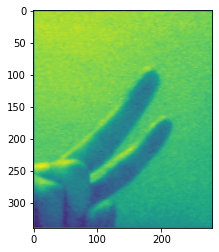

In [7]:
img=cv2.imread('data/0/0_frame_23.png')

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)
img = cv2.resize(img, (320, 120),  
               interpolation = cv2.INTER_NEAREST) 
img = np.array(img, dtype="uint8")
img=img.reshape(1,120,320,1)

print(img.shape)

In [8]:
model =load_model('handrecognition_model.h5')
model.summary()

for layer in model.layers[0:4]:
    layer.trainable = False

model1= Model(inputs=model.input, outputs=model.get_layer('max_pooling2d_3').output)
model1.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 58, 158, 32)       832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 79, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 38, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 36, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5760)           

In [9]:
new_model=Sequential()
new_model.add(model1)
new_model.add(Flatten())
new_model.add(Dense(10, activation='sigmoid'))
new_model.add(Dense(3, activation='softmax'))
new_model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 5, 18, 64)         56256     
_________________________________________________________________
flatten_1 (Flatten)          (None, 5760)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                57610     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 113,899
Trainable params: 94,571
Non-trainable params: 19,328
_________________________________________________________________


In [11]:
import os
imagepaths=[]
for dirname, _, filenames in os.walk('./data'):
   
    
    for filename in filenames:
        path=os.path.join(dirname, filename)
        
        if path.endswith("png"): # We want only the images
              imagepaths.append(path)
    
print(len(imagepaths))
print(imagepaths[0])


11008
./data/0/0_frame_2176.png


In [12]:
X=[]
y=[]


for path in imagepaths:
    img=cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
    img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
    X.append(img)
    
    
    label = int(path.split("/")[2]) # We need to convert 10_down to 00_down, or else it crashes
    y.append(label)

X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 120, 320, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)
print(X.shape)

(11008, 120, 320, 1)


In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9907, 120, 320, 1)
(9907,)
(1101, 120, 320, 1)
(1101,)


In [14]:
new_model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.


In [15]:
hist=new_model.fit(X_train, y_train, epochs=18,  verbose=1, validation_data=(X_test, y_test))
new_model.save('Stone_Paper_Scissors.h5')

Train on 9907 samples, validate on 1101 samples
Epoch 1/18
9907/9907 [==============================] - 64s 6ms/step - loss: 0.4335 - accuracy: 0.8593 - val_loss: 0.2951 - val_accuracy: 0.9228
Epoch 2/18
9907/9907 [==============================] - 46s 5ms/step - loss: 0.2453 - accuracy: 0.9270 - val_loss: 0.2310 - val_accuracy: 0.9346
Epoch 3/18
9907/9907 [==============================] - 46s 5ms/step - loss: 0.1911 - accuracy: 0.9397 - val_loss: 0.1605 - val_accuracy: 0.9510
Epoch 4/18
9907/9907 [==============================] - 46s 5ms/step - loss: 0.1492 - accuracy: 0.9548 - val_loss: 0.1776 - val_accuracy: 0.9401
Epoch 5/18
9907/9907 [==============================] - 46s 5ms/step - loss: 0.1248 - accuracy: 0.9619 - val_loss: 0.1356 - val_accuracy: 0.9555
Epoch 6/18
9907/9907 [==============================] - 47s 5ms/step - loss: 0.1159 - accuracy: 0.9636 - val_loss: 0.1581 - val_accuracy: 0.9510
Epoch 7/18
9907/9907 [==============================] - 47s 5ms/step - loss: 0.093

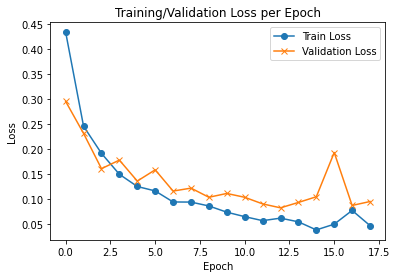

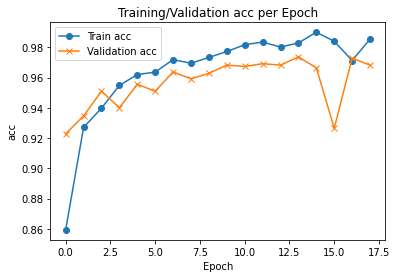

In [16]:

import random
import matplotlib.pyplot as plt

f, ax = plt.subplots()
ax.plot(hist.history['loss'], 'o-')
ax.plot(hist.history['val_loss'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train Loss', 'Validation Loss'], loc = 0)
ax.set_title('Training/Validation Loss per Epoch')
 
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss') 
plt.show()

f, ax = plt.subplots()
ax.plot(hist.history['accuracy'], 'o-')
ax.plot(hist.history['val_accuracy'], 'x-')
ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')

ax.set_xlabel('Epoch')
ax.set_ylabel('acc')
plt.show()

In [17]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

In [18]:
predictions=new_model.predict(X_test)

In [19]:
values=np.argmax(predictions,axis=1)

Accuracy score on validation set :  0.9682107175295186

Claasification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       359
           1       0.99      0.95      0.97       363
           2       0.96      0.98      0.97       379

    accuracy                           0.97      1101
   macro avg       0.97      0.97      0.97      1101
weighted avg       0.97      0.97      0.97      1101


Confusion Matrix:


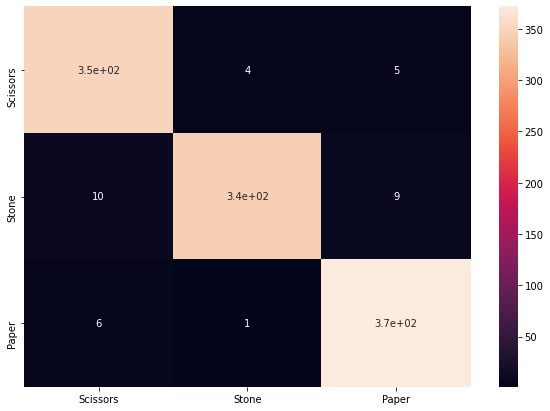

In [20]:
import seaborn as sns
import pandas as pd


print("Accuracy score on validation set : ",accuracy_score(values,y_test))
print("\nClaasification report:")
print(classification_report(values,y_test))

print("\nConfusion Matrix:")

data = confusion_matrix(values, y_test)
df_cm = pd.DataFrame(data, columns=['Scissors','Stone','Paper'], index = ['Scissors','Stone','Paper'])
plt.figure(figsize=(10,7))
sns.heatmap(df_cm,annot=True)
plt.show()